## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA
Reference:

https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl

https://huggingface.co/docs/diffusers/main/en/training/dreambooth

https://huggingface.co/docs/diffusers/main/en/training/lora

## Setup

In [1]:
# Check the GPU
!nvidia-smi

Sat Jun 29 16:40:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               Off | 00000000:00:05.0 Off |                  Off |
| 41%   37C    P8               8W / 140W |      1MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Prepare for training

Check training data and class images.

Please put metadata.jsonl in the screws icon dataset file. We will use this prompt file for training.

In [16]:
# check how many images in the class_images folder
import os
from PIL import Image

def count_images_in_folder(folder_path):
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
    image_count = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            try:
                img = Image.open(os.path.join(folder_path, filename))
                img.verify()  # Verify that it is, in fact, an image
                image_count += 1
            except (IOError, SyntaxError) as e:
                # Not an image or corrupted image
                print(f"File {filename} is not a valid image or is corrupted.")
    
    return image_count

# Example usage
folder_path = 'home depot_screw_class/class_images'
image_count = count_images_in_folder(folder_path)
print(f"Number of images in the folder: {image_count}")


Number of images in the folder: 26


In [17]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

Make sure to install `diffusers` from `main`.

In [5]:
!pip install git+https://github.com/huggingface/diffusers.git -q

In [6]:
# upload the home depot dataset
local_dir='home depot_screw_class/screws'

In [7]:
local_dir

'home depot_screw_class/screws'

#### Preview the images:

In [8]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

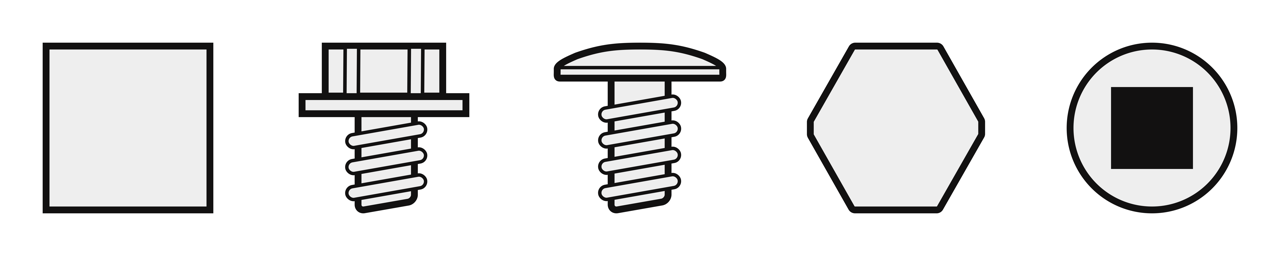

In [9]:
import glob

# change path to display images from your local dir
img_paths = "screw/*.png"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [12]:
import glob
from PIL import Image

# Define the directory containing images
local_dir = "home depot_screw_class/screws/"

# Create a list of (path, PIL.Image) pairs
imgs_and_paths = [(path, Image.open(path)) for path in glob.glob(f"{local_dir}*.png")]


In [13]:
imgs_and_paths

[('home depot_screw_class/screws/hardware-fasteners-screws-562860-drive-style-5295328677-external-square-4296094427-v1.png',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3000x3000>),
 ('home depot_screw_class/screws/hardware-fasteners-screws-562860-head-style-587571-washer-head-4295189252-v1.png',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3000x3000>),
 ('home depot_screw_class/screws/hardware-fasteners-screws-562860-head-style-587571-truss-head-4295189302-v1.png',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3000x3000>),
 ('home depot_screw_class/screws/hardware-fasteners-screws-562860-drive-style-5295328677-external-hex-4296094345-v1.png',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3000x3000>),
 ('home depot_screw_class/screws/hardware-fasteners-screws-562860-drive-style-5295328677-internal-square-4296094329-v1.png',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3000x3000>),
 ('home depot_screw_class/screws/hardware-fasteners-screw

#### Verify if each image listed in the metadata.jsonl file exists in the directory. Check if there are any images in the directory that are not listed in the metadata.jsonl file.



In [19]:
import os
import json

#define the path to the directory containing the images and the metadata file
image_directory = 'home depot_screw_class/screws/'
metadata_file_path = 'home depot_screw_class/screws//metadata.jsonl'

# load the metadata from the jsonl file
metadata = []
with open(metadata_file_path, 'r') as file:
    for line in file:
        try:
            metadata.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line.strip()} - {e}")

# check whether each image in the metadata file exists in the directory
metadata_file_names = [data['file_name'] for data in metadata]
results_metadata_check = []
for file_name in metadata_file_names:
    file_path = os.path.join(image_directory, file_name)
    exists = os.path.exists(file_path)
    results_metadata_check.append({'file_name': file_name, 'exists': exists})

# check if there are any images in the directory that are not listed in the metadata file
directory_file_names = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]
results_directory_check = []
for file_name in directory_file_names:
    listed_in_metadata = file_name in metadata_file_names
    results_directory_check.append({'file_name': file_name, 'listed_in_metadata': listed_in_metadata})

print("Check whether each image in the metadata file exists in the directory:")
for result in results_metadata_check:
    print(f"File: {result['file_name']}, Exists: {result['exists']}")

print("\nCheck whether each image in the directory is listed in the metadata file:")
for result in results_directory_check:
    print(f"File: {result['file_name']}, Listed in Metadata: {result['listed_in_metadata']}")


Check whether each image in the metadata file exists in the directory:
File: hardware-fasteners-screws-562860-head-style-587571-thumb-4295189265-v1.png, Exists: True
File: hardware-fasteners-screws-562860-head-style-587571-countersunk-head-4296088423-v1.png, Exists: True
File: hardware-fasteners-screws-562860-drive-style-5295328677-external-hex-4296094345-v1.png, Exists: True
File: hardware-fasteners-screws-562860-head-style-587571-wafer-head-4295189324-v1.png, Exists: True
File: hardware-fasteners-screws-562860-head-style-587571-button-head-4295189376-v1.png, Exists: True
File: hardware-fasteners-screws-562860-head-style-587571-washer-head-4295189252-v1.png, Exists: True
File: hardware-fasteners-screws-562860-head-style-587571-fillister-head-4295189409-v1.png, Exists: True
File: hardware-fasteners-screws-562860-head-style-587571-socket-head-4295324600-v1.png, Exists: True
File: hardware-fasteners-screws-562860-head-style-587571-round-head-4295189169-v1.png, Exists: True
File: hardware

#### Initialize `accelerate`:

In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

Configuration already exists at /home/paperspace/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


## Train

#### Set Hyperparameters 
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [21]:
!pip install datasets -q

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

### Approach 1: Without Using Class Images:

Advantage: This approach simplifies the dataset preparation and training process since it only requires training images. It can be more straightforward if you want to focus solely on generating images of various screw types without the need for general class images.

Disadvantage: The model might overfit to the specific screw types in your training dataset, potentially losing some generalization capability.

In [7]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="screw1" \
  --output_dir="output3" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of TOK screw icon" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

/home/paperspace/.local/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/home/paperspace/.local/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/h

### Approach 2: Using Class Images and Prior Preservation Loss:

Advantage: Including class images and using prior preservation loss helps the model maintain general characteristics of the class while fine-tuning for specific instances. This can prevent overfitting and ensure the model retains a broad understanding of the general appearance of screws.

Disadvantage: This approach requires additional class images and careful balancing between instance-specific and class-generic images.

Default set the prior_loss_weight to 1. The prior_loss_weight parameter controls the weight of the prior preservation loss during training, which helps to preserve the generalization capabilities of the model by penalizing deviations from the class-specific distribution. We can experiment with this value to find the optimal setting.

In [24]:
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="home depot_screw_class/screws" \
  --instance_prompt="a screw icon" \
  --class_data_dir="home depot_screw_class/class_images" \
  --class_prompt="a screw icon" \
  --output_dir="home depot_screw_class/output" \
  --caption_column="prompt" \
  --mixed_precision="fp16" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=800 \
  --checkpointing_steps=717 \
  --seed="0" \
  --with_prior_preservation \
  --num_class_images=20 \
  --prior_generation_precision="fp16" \
  --prior_loss_weight=1


/home/paperspace/.local/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/home/paperspace/.local/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/h

## Inference

Inference need to install following packages. After installing, you may need to restart the kernel.

In [27]:
!pip install torch torchvision -q

In [28]:
pip install torch --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### Let's generate some images with it!

Use the trained model to do infernce as following:

In [1]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [2]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

# Load the VAE model
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

# Load the pipeline
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)

# upload the pipeline to content, and load LoRA weights from the it
pipe.load_lora_weights("home depot_screw_class/output/pytorch_lora_weights.safetensors")



/home/paperspace/.local/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

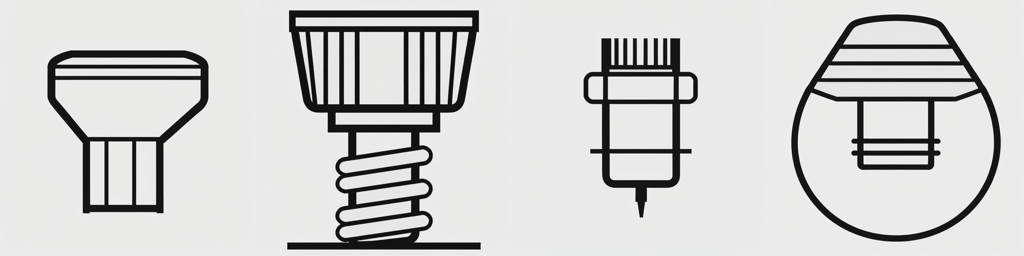

In [34]:
# Move the pipeline to GPU
_ = pipe.to("cuda")

# Generate an image using the loaded model
prompt = "phillips drive oval head screw icon"
# num_images_per_prompt=4
images = pipe(prompt, num_inference_steps= 125,num_images_per_prompt=4).images
image_grid(images, 1,4)

In [35]:
# Save the inference prompt
with open('home depot_screw_class/prompt_for_inference/phillips_oval.txt','w') as f:
    f.write(prompt)
    
# save the generated images
for i, image in enumerate(images):
    image.save(f"home depot_screw_class/inference_images/phillips_oval_{i}.png")

In [36]:
torch.cuda.empty_cache()

In [ ]:
# Use a for loop to get all the infusion images
prompts=["round head screw icon",
         "square head screw icon",
         "hex head screw icon",
         "flat head screw icon",
         "phillips drive screw icon",
         "spanner drive screw icon",
         "slotted drive screw icon",
         "cross drive round head screw icon",
        "spanner drive pan head screw icon",
        "phillips drive oval head screw icon"]
for prompt in prompts:
    _ = pipe.to("cuda")
    images = pipe(prompt, num_inference_steps= 125,num_images_per_prompt=4).images
    with open(f"{prompt}.txt","w") as f:
        f.write(prompt)
    for i, image in enumerate(images):
        image.save(f"{prompt}_{i}.png")
    torch.cuda.empty_cache()

Make zip file in order to download

In [52]:
import os

directory_to_zip = 'home depot_screw_class/inference_images'

if os.path.exists(directory_to_zip):
    for root, dirs, files in os.walk(directory_to_zip):
        print(f"Root: {root}")
        print(f"Directories: {dirs}")
        print(f"Files: {files}")
else:
    print(f"Directory {directory_to_zip} does not exist.")


Root: home depot_screw_class/inference_images
Directories: []
Files: ['phillips_oval_2.png', 'spanner_drive_2.png', 'round_head_3.png', 'ross_round_0.png', 'slotted_drive_2.png', 'flat_head_2.png', 'square_head_2.png', 'spanner_pan_2.png', 'hex_head_0.png', 'phillips_drive_3.png', 'hex_head_2.png', 'round_head_2.png', 'square_head_3.png', 'spanner_pan_0.png', 'phillips_oval_0.png', 'flat_head_1.png', 'round_head_0.png', 'slotted_drive_1.png', 'ross_round_3.png', 'flat_head_3.png', 'phillips_oval_1.png', 'phillips_oval_3.png', 'round_head_1.png', 'slotted_drive_3.png', 'square_head_0.png', 'ross_round_1.png', 'spanner_drive_3.png', 'phillips_drive_0.png', 'hex_head_3.png', 'spanner_drive_1.png', 'square_head_1.png', 'phillips_drive_2.png', 'hex_head_1.png', 'spanner_pan_3.png', 'phillips_drive_1.png', 'spanner_drive_0.png', 'spanner_pan_1.png', 'slotted_drive_0.png', 'ross_round_2.png', 'flat_head_0.png']


In [53]:
import shutil


directory_to_zip = 'home depot_screw_class/inference_images'

output_zip_path = 'inference_images'

# Create the zip file
shutil.make_archive(output_zip_path, 'zip', directory_to_zip)


'/home/paperspace/inference_images.zip'